<a href="https://colab.research.google.com/github/ronnie9610/data_analysis/blob/main/face_data_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# time
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Implementing DCGANs in Keras
# attesting the paper links
Paper that described the type of DCGAN [[Cite:radford2015unsupervised]](https://arxiv.org/abs/1511.06434) 
DCGAN as follows:


* [Deep Convolutional Generative Adversarial Network (TensorFlow 2.0 example code)](https://www.tensorflow.org/tutorials/generative/dcgan)
* [Keep Calm and train a GAN. Pitfalls and Tips on training Generative Adversarial Networks](https://medium.com/@utk.is.here/keep-calm-and-train-a-gan-pitfalls-and-tips-on-training-generative-adversarial-networks-edd529764aa9)
* [Collection of Keras implementations of Generative Adversarial Networks GANs](https://github.com/eriklindernoren/Keras-GAN)
* [dcgan-facegenerator](https://github.com/platonovsimeon/dcgan-facegenerator), [Semi-Paywalled Article by GitHub Author](https://medium.com/datadriveninvestor/generating-human-faces-with-keras-3ccd54c17f16)





In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: not using Google CoLab


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

The datasret we are using 
* [Kaggle Faces Data New](https://www.kaggle.com/gasgallo/faces-data-new)
* [ celeba img ](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# defining the Generation resolution - preffered and Must be square 
# Training data is also and should scaled to this.
# Note GENERATE_RES 4 or higher  resolution is user defined

GENERATE_RES = 3 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# check and Preview image 
PREVIEW_ROWS = 2
PREVIEW_COLS = 5
PREVIEW_MARGIN = 20

# Size vector to generate images from
SEED_SIZE = 200

# Configuration of image
DATA_PATH ='/content/drive/MyDrive/projects/samples'
EPOCHS = 500
BATCH_SIZE = 32
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 96px square images.


Next we will load and preprocess the images.  This can take awhile.  Google CoLab took around an hour to process.  Because of this we store the processed file as a binary.  This way we can simply reload the processed training data and quickly use it.  It is most efficient to only perform this operation once.  The dimensions of the image are encoded into the filename of the binary file because we need to regenerate it if these change.

In [ ]:
#total images = 11000+ images.

# after 20 failed attempt took a sample of around 600 images for testing 

# took long time to generate even few samples

# Because of this time needed, save a Numpy preprocessed file.

# Note, that file is large enough to cause problems for any computer even colab gpu 

# so Numpy binary files are used.
training_binary_path = os.path.join(DATA_PATH,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  
  testing_data = []
  faces_path = os.path.join(DATA_PATH,'face_images')
  for filename in tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path,filename)
      image = Image.open(path).resize((GENERATE_SQUARE,
            GENERATE_SQUARE),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.
  # testing_data=training_data / 127.5 - 1.

  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
  print (f'Image preprocess time: {hms_string(elapsed)}')
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)

Looking for file: /content/drive/MyDrive/projects/samples/training_data_96_96.npy
Loading previous training pickle...


In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data) \
    .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# test_dataset=tf.data.Dataset.from_tensor_slices(training_data) \ .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Next we actually build the discriminator and the generator.  
Both will be trained with the Adam optimizer.

In [ ]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final layer of CNN
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model


def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

As we progress through training images will be produced to show the progress.  These images will contain a number of rendered faces that show how good the generator has become.  These faces will be 

In [ ]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), IMAGE_CHANNELS), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

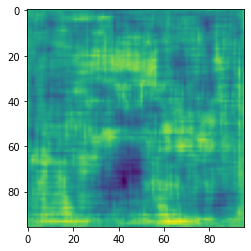

In [ ]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)
# generator.compiled_metrics==0
plt.imshow(generated_image[0, :, :, 0])

In [ ]:
generator.load_weights(os.path.join(DATA_PATH,"face_generator1.h5"))


In [ ]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.50042564]], shape=(1, 1), dtype=float32)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [ ]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    # if (epoch = EPOCHS/2)

    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
           f' {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')


In [ ]:
EPOCHS=10

In [ ]:
train(train_dataset, EPOCHS)

Epoch 1, gen loss=1.2779361009597778,disc loss=1.2014590501785278, 0:00:18.56
1/1 [==============================] - 1s 612ms/step
Epoch 2, gen loss=1.5251572132110596,disc loss=1.0574214458465576, 0:00:02.58
1/1 [==============================] - 0s 21ms/step
Epoch 3, gen loss=1.612088918685913,disc loss=1.030010461807251, 0:00:02.53
1/1 [==============================] - 0s 21ms/step
Epoch 4, gen loss=2.1065497398376465,disc loss=0.9617473483085632, 0:00:02.55
1/1 [==============================] - 0s 30ms/step
Epoch 5, gen loss=2.399649143218994,disc loss=0.8383410573005676, 0:00:02.55
1/1 [==============================] - 0s 22ms/step
Epoch 6, gen loss=2.3064146041870117,disc loss=0.9734083414077759, 0:00:02.55
1/1 [==============================] - 0s 20ms/step
Epoch 7, gen loss=2.6178221702575684,disc loss=0.9277856945991516, 0:00:02.56
1/1 [==============================] - 0s 21ms/step
Epoch 8, gen loss=2.274928331375122,disc loss=1.1092870235443115, 0:00:02.57
1/1 [==========

In [ ]:
# generator.save(os.path.join(DATA_PATH,"face_generator1.h5"))

In [ ]:
EPOCHS=5000

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
generator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
generator.save(os.path.join(DATA_PATH,"face_generator1.h5"))

In [ ]:
# train(train_dataset, EPOCHS)

In [ ]:
# train(train_dataset, EPOCHS)

In [ ]:
# train(train_dataset, EPOCHS)

In [ ]:
generator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
generator.save(os.path.join(DATA_PATH,"face_generator1.h5"))

In [ ]:
EPOCHS=500

In [ ]:
train(train_dataset, EPOCHS)

Epoch 1, gen loss=16.32544708251953,disc loss=0.1276872605085373, 0:00:02.59
1/1 [==============================] - 0s 124ms/step
Epoch 2, gen loss=19.24913787841797,disc loss=0.026899125427007675, 0:00:02.59
1/1 [==============================] - 0s 27ms/step
Epoch 3, gen loss=18.201622009277344,disc loss=0.11570917069911957, 0:00:02.60
1/1 [==============================] - 0s 37ms/step
Epoch 4, gen loss=18.630701065063477,disc loss=0.07761690765619278, 0:00:02.59
1/1 [==============================] - 0s 19ms/step
Epoch 5, gen loss=16.837509155273438,disc loss=0.03923135623335838, 0:00:02.59
1/1 [==============================] - 0s 19ms/step
Epoch 6, gen loss=13.176942825317383,disc loss=0.010233884677290916, 0:00:02.60
1/1 [==============================] - 0s 19ms/step
Epoch 7, gen loss=11.661343574523926,disc loss=0.025765767320990562, 0:00:02.60
1/1 [==============================] - 0s 31ms/step
Epoch 8, gen loss=13.455375671386719,disc loss=0.04778685048222542, 0:00:02.60
1/1

In [ ]:
generator.save(os.path.join(DATA_PATH,"face_generator1.h5"))

In [ ]:
np.save(training_binary_path,training_data)